# Build classifiers based on the Forbes dataset, then attempt to explain the model.

## Import and configure

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

from matplotlib import pyplot as plt
from xgboost import XGBClassifier, XGBRegressor

from config import DATASET_PATH

/Users/ducnguyen/workspaces/lab/forbes-classifier/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Configurations for the classifier
categorical_columns = ["Industry", "Country", "Company", "Market_Value_class", "Sales_class", "Profits_class", "Assets_class", "Rank_class"]
noise_features = ["DBpedia_URI"]
target_feature = "Rank_class"
test_size = 0.15

## Load and split the dataset

In [3]:
# Load and preprocess the dataset
dataset = pd.read_csv(DATASET_PATH)

if target_feature == "Market_Value_class":
    noise_features.append("Market_Value")
elif target_feature == "Sales_class":
    noise_features.append("Sales")
elif target_feature == "Profits_class":
    noise_features.append("Profits")
elif target_feature == "Assets_class":
    noise_features.append("Assets")
elif target_feature == "Rank_class":
    noise_features.append("Rank")

dataset.drop(columns=dataset.columns[0], axis=1, inplace=True)
dataset.drop(columns=noise_features, axis=1, inplace=True)

# One hot encoding categorial columns
dataset = pd.get_dummies(dataset, columns=[elm for elm in categorical_columns if elm != target_feature], drop_first=True)
dataset.head()

,Market_Value,Sales,Profits,Assets,Rank_class,Industry_Aerospace_&_Defense,Industry_Air_Courier,Industry_Airline,Industry_Aluminum,Industry_Apparel/Accessories,...,Company_Zodiac_Aerospace,Company_Zoetis,Company_Zurich_Insurance_Group,Market_Value_class_low,Market_Value_class_mid,Sales_class_low,Sales_class_mid,Profits_class_low,Profits_class_mid,Assets_class_mid
0,9.5,7.6,0.1,14.5,high,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
1,11.9,12.5,0.4,11.5,mid,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
2,16.0,17.2,0.7,122.1,low,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
3,81.2,37.5,5.9,666.9,low,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.1,2.8,0.0,43.0,high,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1


In [4]:
# Split dataset for training
def encode_label(dataframe):
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(dataframe)
    return label_encoder.transform(dataframe)

def split_dataset(dataset, target_column = target_feature, test_size = test_size):
    y = encode_label(dataset[target_column])
    x = dataset.drop(target_column, axis=1)
    return x, y

x_train, y_train = split_dataset(dataset)

In [5]:
x_train

,Market_Value,Sales,Profits,Assets,Industry_Aerospace_&_Defense,Industry_Air_Courier,Industry_Airline,Industry_Aluminum,Industry_Apparel/Accessories,Industry_Apparel/Footwear_Retail,...,Company_Zodiac_Aerospace,Company_Zoetis,Company_Zurich_Insurance_Group,Market_Value_class_low,Market_Value_class_mid,Sales_class_low,Sales_class_mid,Profits_class_low,Profits_class_mid,Assets_class_mid
0,9.5,7.6,0.1,14.5,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
1,11.9,12.5,0.4,11.5,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
2,16.0,17.2,0.7,122.1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
3,81.2,37.5,5.9,666.9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.1,2.8,0.0,43.0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1580,24.3,5.0,3.9,17.1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
1581,31.6,13.6,1.6,9.0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
1582,12.5,4.5,0.8,9.0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,1
1583,4.7,2.5,0.3,55.5,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1


In [6]:
y_train

array([0, 2, 1, ..., 2, 0, 0])

## Train the model

In [7]:
model = XGBRegressor().fit(x_train, y_train)

## Explain the model

In [8]:
import shap

In [9]:
explainer = shap.Explainer(model)
shap_values = explainer(x_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


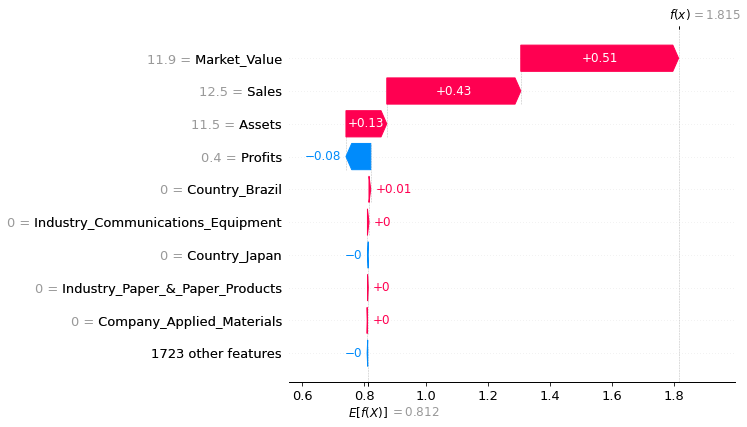

In [10]:
shap.plots.waterfall(shap_values[1])

In [11]:
shap.initjs()
shap.plots.force(shap_values[0])

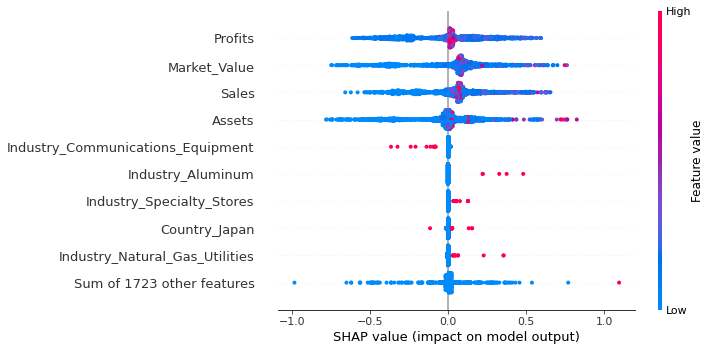

In [12]:
shap.plots.beeswarm(shap_values)

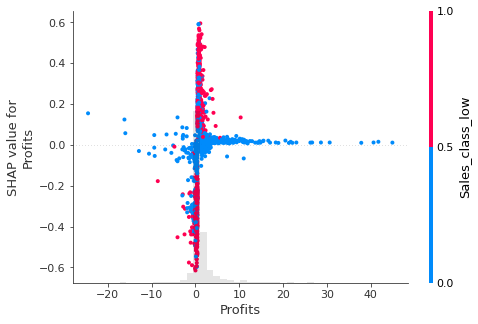

In [13]:
shap.plots.scatter(shap_values[:,"Profits"], color=shap_values)

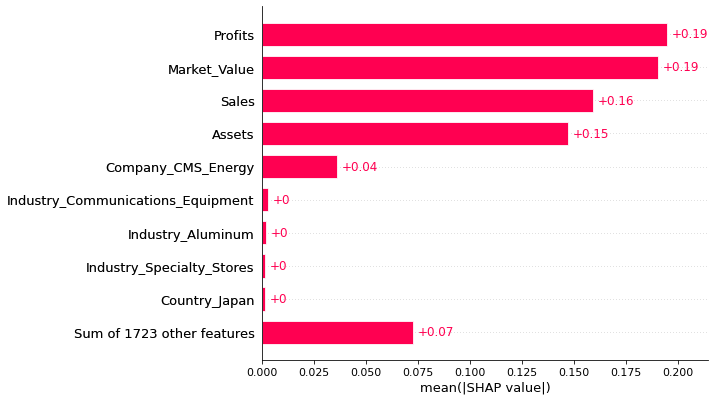

In [14]:
shap.plots.bar(shap_values)